In [1]:
import numpy as np
import astropy.io.fits
import random
import os
import os.path
from sklearn.cluster import KMeans
from astropy.time import Time
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import silhouette_samples, silhouette_score
import cudf
from cuml.cluster import DBSCAN
import timeit
from cuml.neighbors import NearestNeighbors
from cuml.cluster import KMeans as cudkmean


In [19]:

# Normalizing between [1,-1]
def normal(a):
    
    aa = a - a.min()
    bb = a.max() - a.min()
    cc = (2 * aa) / bb
    dd = cc - 1
    return dd


# Unnormal

def unnormal(norm, pure):
    ee = norm + 1
    ff = ee/2
    gg = ff * (pure.max() - pure.min())
    hh = gg + pure.min()
    return hh


# Getting Features

def getFeatures(Name):
    fileData = astropy.io.fits.open(Name)
    B = fileData[1].data
    B = np.array(B, dtype=np.float64)
    Binc = fileData[2].data
    Binc = np.array(Binc, dtype=np.float64)
    Bazi = fileData[3].data
    Bazi = np.array(Bazi, dtype=np.float64)
    DopF = fileData[4].data
    DopF = np.array(DopF, dtype=np.float64)
    #DopS = fileData[5].data
    #DopS = np.array(DopS, dtype=np.float64)
    SLFF = fileData[12].data
    SLFF = np.array(SLFF, dtype=np.float64)
    CI = fileData[32].data
    CI = np.array(CI, dtype=np.float64)


    return B, Binc, Bazi, DopF, SLFF, CI


# Removing that effect due to doppler shifts

def canNoise(Doppler):
    
    y = np.mean(Doppler, 0)
    x = np.array(range(Doppler.shape[1]))
    m, b = np.polyfit(x, y, 1)
    v = m*x + b
    out = Doppler - v

    return out

# Normalizing angles

def normangle(feature):
    
    
    a = np.cos(np.deg2rad(feature))
    
    return a


# Concatenating all the observations

def concatfeatures(NewList):

    Btot, Binctot, DopFtot, SLFFtot, CItot = np.array([]), np.array([]),np.array([]), np.array([]),np.array([])



    for j in NewList:

        B, Binc, Bazi, DopF, SLFF, CI = getFeatures(j)
        Btot = np.concatenate((Btot, B), axis=None)
        Binctot = np.concatenate((Binctot, Binc), axis=None)
        DopFtot = np.concatenate((DopFtot, canNoise(DopF)), axis=None)
        SLFFtot = np.concatenate((SLFFtot, SLFF), axis=None)
        CItot = np.concatenate((CItot, CI), axis=None)
    
    
    return Btot, Binctot, DopFtot, SLFFtot, CItot

# A function to get a window of w*w from each map as a subsample

def confe(NewList, w):

    Btot, Binctot, DopFtot, SLFFtot, CItot = np.array([]), np.array([]),np.array([]), np.array([]),np.array([])



    for j in NewList:

        B, Binc, Bazi, DopF, SLFF, CI = getFeatures(j)
        x, y = B.shape
        yy = random.randint(0, y-(w+1))
        xx = random.randint(0, x-(w+1))
        
        BB = B[xx:xx+w, yy:yy+w]
        
        BBinc = Binc[xx:xx+w, yy:yy+w]
        
        DopFF = canNoise(DopF)
        DDopF = DopFF[xx:xx+w, yy:yy+w]
        
        FF = SLFF[xx:xx+w, yy:yy+w]
        
        CCI = CI[xx:xx+w, yy:yy+w]

        Btot = np.concatenate((Btot, BB), axis=None)
        Binctot = np.concatenate((Binctot, BBinc), axis=None)
        DopFtot = np.concatenate((DopFtot, DDopF), axis=None)
        SLFFtot = np.concatenate((SLFFtot, FF), axis=None)
        CItot = np.concatenate((CItot, CCI), axis=None)
    
    
    return Btot, Binctot, DopFtot, SLFFtot, CItot





# Plot mappings
def pltmaps(labels, dimList):
    
    start = 0
    end = 0

    for s, tple in enumerate(dimList):

        end += tple[0] * tple[1]

        pltimg(labels[start:end], tple, s)

        start = end 
        
def pltimg(labels, tple, s):
    
    fileData = (NewList[s])
    v = fileData[42:-5]
    labless = labels.reshape(tple)
    plt.figure(figsize=(16,9))
    plt.imshow(labless, cmap="plasma", origin="bottom")
    plt.colorbar()
    plt.savefig(dir+'/'+ v + '.png')
    

# Making a list for dimensions of observations
def dimlist(filenames):
    
    dimList = list()


    for i in NewList:

        file = astropy.io.fits.open(i)
        x, y = file[1].data.shape
        dimList.append((x, y))
    
    return dimList

In [5]:
# Reading our files in related directory
NorthDir='/glade/work/egeland/hinode_synoptic/north'
allfiles = [os.path.join(NorthDir, f) for f in sorted(os.listdir(NorthDir))]

# Removing all sav files
NewList=[item for i,item in enumerate(allfiles) if i%2==0]
b = []

#Getting only fastmaps
for item in NewList:
    
    fileData = astropy.io.fits.open(item)
    a = fileData[0].header['YSCALE']
    if a > 0.16 :
        b.append(item)
        
NewList = b


NewList = NewList[:3]
dimList = dimlist(NewList)
# concatenating all samples(pixels) in each feature
Btot, Binctot, DopFtot, SLFFtot, CItot = concatfeatures(NewList[:3])

for it, item in enumerate(Btot):
    
    if item < 200:
        
        Btot[it] = 0
        Binctot[it] = 90
        SLFFtot[it] = 0
        
    elif item > 2000:
        
        Btot[it] = 2000
        
        

# Normalizing Features
Btotn = normal(Btot)
Binctotn = normangle(Binctot)
DopFtotn = normal(DopFtot)
SLFFtotn = normal(SLFFtot)
CItotn = normal(CItot)

# Preparing the input for our clustering method
da = np.array([Btotn, Binctotn, DopFtotn, SLFFtotn, CItotn])
fda = np.transpose(da)
print(fda.shape)

(1395712, 5)


In [6]:
start = timeit.default_timer()
X_cudf = cudf.DataFrame.from_gpu_matrix(fda)
model = NearestNeighbors(n_neighbors=2)
model.fit(X_cudf)

# get 3 nearest neighbors
distances, indices = model.kneighbors(X_cudf)
stop = timeit.default_timer()
print('Time: ', stop - start) 

Time:  31.790506523102522


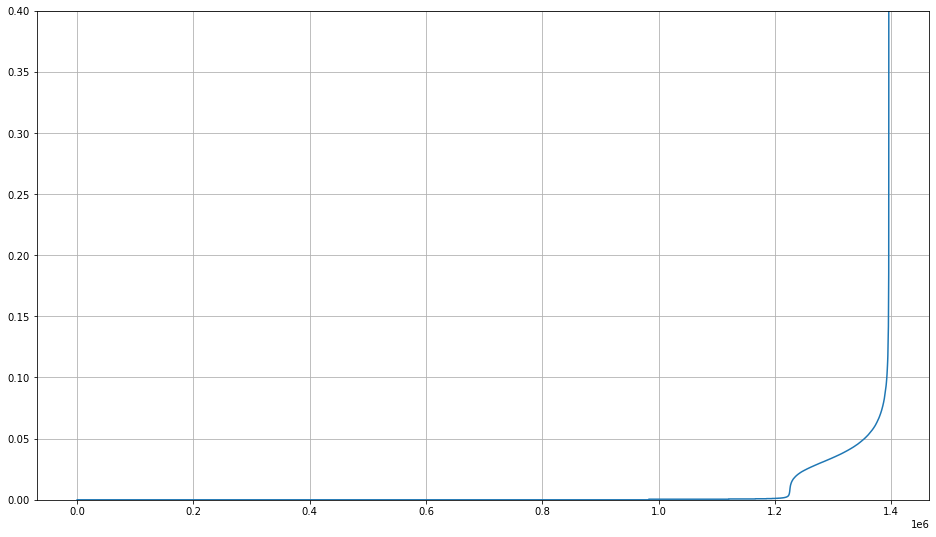

In [7]:
distancess = np.sort(distances.as_matrix(), axis=0)
distancesss = distancess[:,1]
plt.figure(figsize=(16,9))
plt.grid(True)
plt.ylim((0, 0.4)) 
plt.plot(distancesss)

#### Eps sounds to be 0.05

In [10]:
print(dimList)
print(512*755)
504832 + (512*755)

[(512, 986), (512, 755), (512, 985)]
386560


891392

In [ ]:
cudf.set_allocator("managed")
start = timeit.default_timer()
db = DBSCAN(eps=0.05, min_samples=100).fit(X_cudf)
db_labels = db.labels_
#silhouette_avg1 = silhouette_score(fda[:504832], db_labels.to_array()[:504832])
silhouette_avg2 = silhouette_score(fda[504832:891392], db_labels.to_array()[504832:891392])
#silhouette_avg3 = silhouette_score(fda[891392:], db_labels.to_array()[891392:])

#print(silhouette_avg1)
print(silhouette_avg2)
#print(silhouette_avg3)

stop = timeit.default_timer()
print('Time: ', stop - start)

In [23]:
np.unique(db.labels_)

0   -1
1    0
dtype: int32

In [14]:
start = timeit.default_timer()

cud = cudkmean(n_clusters = 12)
cud.fit(X_cudf)
km_labels = cud.labels_
#silhouette_avg1 = silhouette_score(fda[:504832],  km_labels.to_array()[:504832])
silhouette_avg2 = silhouette_score(fda[504832:891392], km_labels.to_array()[504832:891392])
#silhouette_avg3 = silhouette_score(fda[891392:], km_labels.to_array()[891392:])

print(silhouette_avg1)
print(silhouette_avg2)
print(silhouette_avg3)
stop = timeit.default_timer()

print('Time: ', stop - start) 

In [15]:
print(silhouette_avg2)

0.35512734401585927


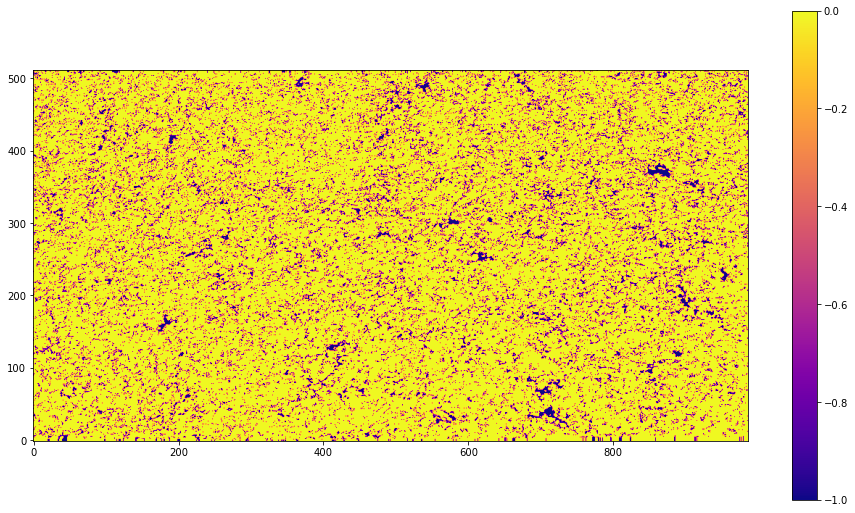

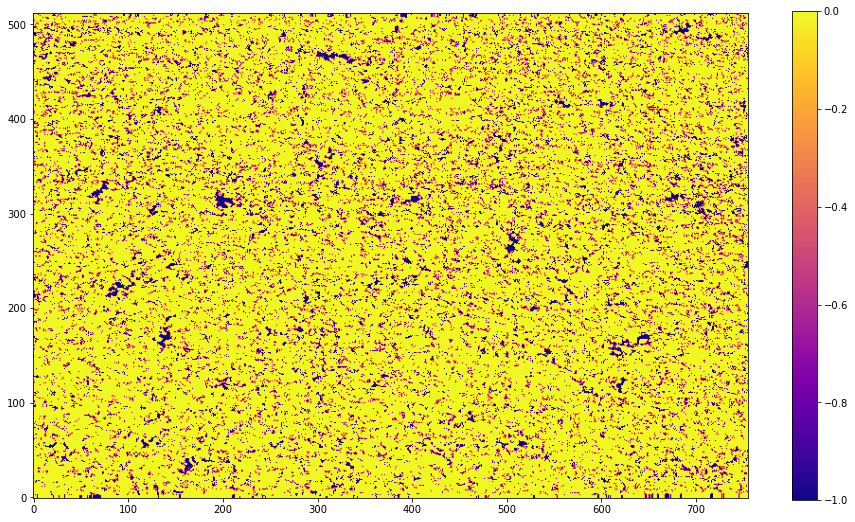

In [20]:
## ploting dbscan results
dir = "db"
pltmaps(db_labels.to_array(), dimList)

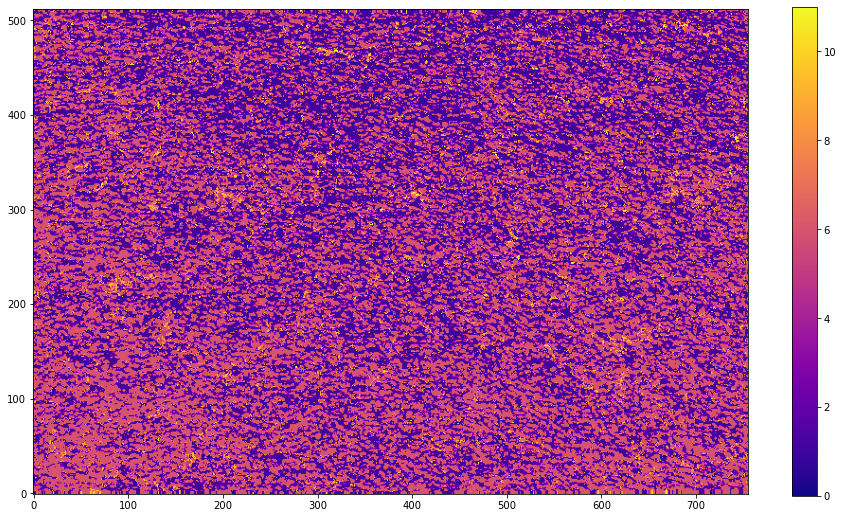

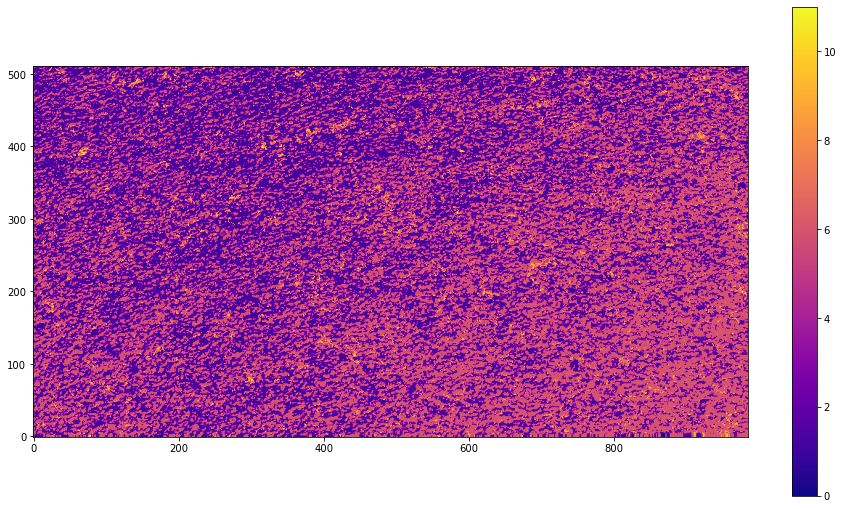

In [21]:
## ploting kmeans results
dir = "km"
pltmaps(km_labels.to_array(), dimList)